# Analyze met data at each site
- Diurnal plots of Tsurf

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Open data

In [6]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

# Dictionaries for iterating
met = {'SWA': SWA,
       'SNQ': SNQ,
       'CDP': CDP}

In [5]:
# --------------------------------------------------------------------------------------------
# Add bulk stability measure to each site
RiBulk,_,_ = turbpy.bulkRichardson(SWA.Tair + 273.15, SWA.Tsrf + 273.15, SWA.WIND, 6 - SWA.snowDepth)
SWA['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(SNQ.Tair + 273.15, SNQ.Tsrf + 273.15, SNQ.WIND, 6 - SNQ.snowDepth)
SNQ['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 6 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in multiply
  if not reflexive


## Functions

In [38]:
# --------------------------------------------------------------------------------------------
# Groupby water year
def water_year(time_index, last_month=9):
    '''
    Example usage:
    wy = SNOTEL.groupby(water_year(SNOTEL.t))
    Returns a groupby object of wy. Allows iteration by water year. A little clunky to use still...
    '''
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

In [1]:
# ----------------------------------------------------------------------------------------------
# Diurnal plotting routine
def diurnal(ds, field, ax, color):
#     colors = sns.color_palette("coolwarm", 7)
    hours = np.arange(0, 24)
    
    # Plot longwave radiative fluxes
    ax.plot(hours, ds[field], label=field, color=colors[-1])
    
    # Format
    ax.set_xlim(0, 23)

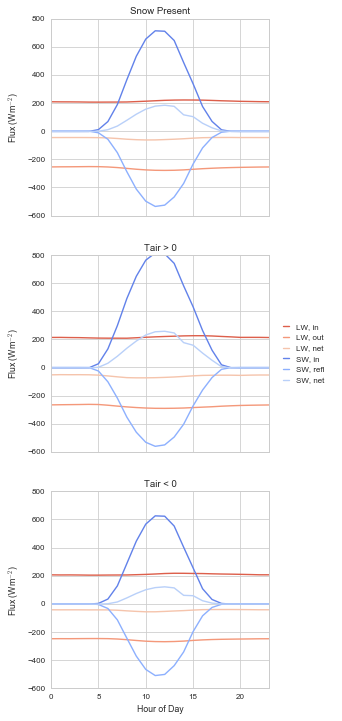

In [32]:
# ----------------------------------------------------------------------------------------------
# Plot diurnal composites
# Set-up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# ----------------------------------------------------------------------------------------------
# All data -- snow present
ds = SWA.where(SWA.SP, drop=True)
ds = SWA.groupby('time.hour').mean(dim='time')
ax.plot(hours, ds.snowTs, label='SP')

# ----------------------------------------------------------------------------------------------
# Daily air temperature > 0
ds = senator.where((senator.Tair > 0) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[1, 0])

subPlotDiurnalEB(ds, ax, 'Tair > 0', ylab=True)
ax.set_ylabel("Flux (Wm$^{-2}$)")


# ----------------------------------------------------------------------------------------------
# Air temperature < 0
ds = senator.where((senator.Tair < 0) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[2, 0])

subPlotDiurnalEB(ds, ax, 'Tair < 0', ylab=True, xlab=True)
ax.set_ylabel("Flux (Wm$^{-2}$)")
ax.set_xlabel("Hour of Day")

# ----------------------------------------------------------------------------------------------
# Legend
handles, labels = ax.get_legend_handles_labels()
axLegend = plt.subplot(gs[:, 1])
axLegend.axis('off')
axLegend.legend(handles, labels, handlelength=.8, loc='center left')

# plt.tight_layout()

os.chdir(dirPrint)
fig.savefig('SNQ.DiurnalRadiation.airTemp.png')

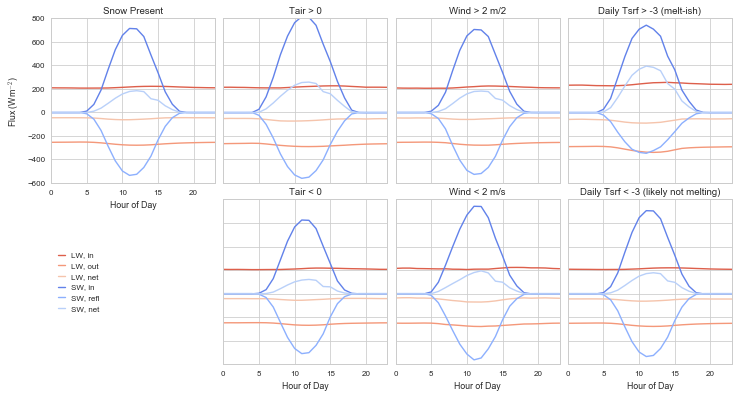

In [35]:
# ----------------------------------------------------------------------------------------------
# Diurnal composites depending on air temperature, wind, and melt
# Set-up figure
fig = plt.figure(figsize=(12.2, 6.2))
gs = matplotlib.gridspec.GridSpec(2, 4, wspace=0.05, hspace=0.1)
hours = np.arange(0, 24)

# ----------------------------------------------------------------------------------------------
# All data -- snow present
ds = senator.where(senator.SP, drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[0, 0])

subPlotDiurnalEB(ds, ax, 'Snow Present', ylab=True, xlab=True)
ax.set_ylabel("Flux (Wm$^{-2}$)")
ax.set_xlabel("Hour of Day")

# ----------------------------------------------------------------------------------------------
# Daily air temperature > 0
ds = senator.where((senator.Tair > 0) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[0, 1])

subPlotDiurnalEB(ds, ax, 'Tair > 0')

# ----------------------------------------------------------------------------------------------
# Air temperature < 0
ds = senator.where((senator.Tair < 0) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[1, 1])

subPlotDiurnalEB(ds, ax, 'Tair < 0', xlab=True)
ax.set_xlabel("Hour of Day")

# ----------------------------------------------------------------------------------------------
# windy
ds = senator.where((senator.WIND > 2) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[0, 2])
subPlotDiurnalEB(ds, ax, 'Tair < 0')
ax.set_title('Wind > 2 m/2')

# ----------------------------------------------------------------------------------------------
# Not windy
ds = senator.where((senator.WIND < 2) & (senator.SP), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[1, 2])
subPlotDiurnalEB(ds, ax, 'Tair < 0', xlab=True)
ax.set_xlabel("Hour of Day")
ax.set_title('Wind < 2 m/s')

# ----------------------------------------------------------------------------------------------
# Non-melt
ds = senator.where((dailyDS.Tsrf > -3), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[0, 3])
subPlotDiurnalEB(ds, ax, 'Daily Tsrf > -3 (melt-ish)')

# ----------------------------------------------------------------------------------------------
# Non-melt
ds = senator.where((dailyDS.Tsrf < -3), drop=True)
ds = ds.groupby('time.hour').mean(dim='time')

ax = plt.subplot(gs[1, 3])
subPlotDiurnalEB(ds, ax, 'Daily Tsrf < -3 (likely not melting)', xlab=True)
ax.set_xlabel("Hour of Day")

# ----------------------------------------------------------------------------------------------
# Legend
handles, labels = ax.get_legend_handles_labels()
axLegend = plt.subplot(gs[1, 0])
axLegend.axis('off')
axLegend.legend(handles, labels, handlelength=.8, loc='center left')

# Save!
os.chdir(dirPrint)
fig.savefig('SBSP.DiurnalRadiation.All.png')


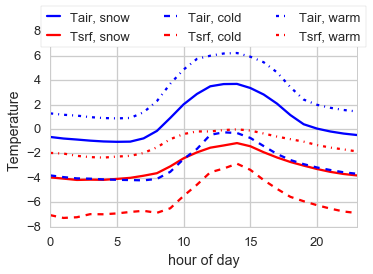

In [133]:
# ----------------------------------------------------------------------------------------------
# Plot diurnal composites
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
hours = np.arange(0, 24)

# ----------------------------------------------------------------------------------------------
# All data
meltDS = support.where(support.SP, drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, 'b', label='Tair, snow')
ax.plot(hours, meltDS.Tsrf, 'r', label='Tsrf, snow')

# ----------------------------------------------------------------------------------------------
# Cold
meltDS = support.where((dailyDS.T6 < 0) & (support.SP), drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '--b', label='Tair, cold')
ax.plot(hours, meltDS.Tsrf, '--r', label='Tsrf, cold')

# ----------------------------------------------------------------------------------------------
# Warm
meltDS = support.where((dailyDS.T6 > 0) & (support.SP), drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '-.b', label='Tair, warm')
ax.plot(hours, meltDS.Tsrf, '-.r', label='Tsrf, warm')

# ----------------------------------------------------------------------------------------------
# Format
ax.set_xlim(0, 23)
ax.set_ylabel('Temperature')
ax.set_xlabel('hour of day')
ax.legend(bbox_to_anchor=(-.05, 1.06, 1.1, .102), frameon='True', ncol=3, handlelength=1, mode='expand')


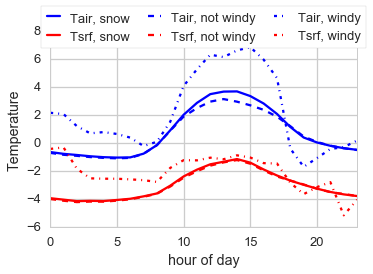

In [132]:
# ----------------------------------------------------------------------------------------------
# Plot diurnal composites
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
hours = np.arange(0, 24)

# ----------------------------------------------------------------------------------------------
# All data
meltDS = support.where(support.SP, drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, 'b', label='Tair, snow')
ax.plot(hours, meltDS.Tsrf, 'r', label='Tsrf, snow')

# ----------------------------------------------------------------------------------------------
# Cold
meltDS = support.where((support.WIND < 2) & (support.SP), drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '--b', label='Tair, not windy')
ax.plot(hours, meltDS.Tsrf, '--r', label='Tsrf, not windy')

# ----------------------------------------------------------------------------------------------
# Warm
meltDS = support.where((support.WIND > 2) & (support.SP), drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '-.b', label='Tair, windy')
ax.plot(hours, meltDS.Tsrf, '-.r', label='Tsrf, windy')

# ----------------------------------------------------------------------------------------------
# Format
ax.set_xlim(0, 23)
ax.set_ylabel('Temperature')
ax.set_xlabel('hour of day')
ax.legend(bbox_to_anchor=(-.05, 1.06, 1.1, .102), frameon='True', ncol=3, handlelength=1, mode='expand')


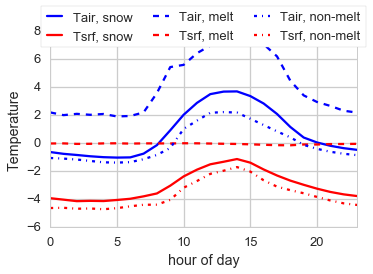

In [150]:
# ----------------------------------------------------------------------------------------------
# Plot diurnal composites
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
hours = np.arange(0, 24)

# ----------------------------------------------------------------------------------------------
# All data
meltDS = support.where(support.SP, drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, 'b', label='Tair, snow')
ax.plot(hours, meltDS.Tsrf, 'r', label='Tsrf, snow')

# ----------------------------------------------------------------------------------------------
# Melt
meltDS = support.where((dailyDS.Lysimeter > 0)
                       & (support.Precip == 0)
                       & (support.Tsrf > -.5)
                       & (support.Tsrf < .5)
                       & support.SP,
                       drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '--b', label='Tair, melt')
ax.plot(hours, meltDS.Tsrf, '--r', label='Tsrf, melt')

# ----------------------------------------------------------------------------------------------
# Non-melt
meltDS = support.where(np.invert((dailyDS.Lysimeter > 0)
                       & (support.Precip == 0)
                       & (support.Tsrf > -.5)
                       & (support.Tsrf < .5))
                       & support.SP,
                       drop=True)
meltDS = meltDS.groupby('time.hour').mean(dim='time')

ax.plot(hours, meltDS.T6, '-.b', label='Tair, non-melt')
ax.plot(hours, meltDS.Tsrf, '-.r', label='Tsrf, non-melt')

# ----------------------------------------------------------------------------------------------
# Format
ax.set_xlim(0, 23)
ax.set_ylabel('Temperature')
ax.set_xlabel('hour of day')
ax.legend(bbox_to_anchor=(-.05, 1.06, 1.1, .102), frameon='True', ncol=3, handlelength=1.2, mode='expand')
